
1. **Self-Attention**: 
  <span style="color:cyan">
  $$
  \text{Output} = \text{softmax}\left(\frac{Q K^T}{\sqrt{d_k}}\right) V
  $$
  </span>

2. **Causal Attention**:
  <span style="color:cyan">
  $$
 \quad \text{Output} = \text{softmax}\left(\frac{Q K^T + M}{\sqrt{d_k}}\right) V
  $$
  </span>

3. **Cross-Attention**:
  <span style="color:cyan">
  $$
  \text{Output} = \text{softmax}\left(\frac{Q_{\text{decoder}} K_{\text{encoder}}^T}{\sqrt{d_k}}\right) V_{\text{encoder}}
  $$
  </span>

#### 1. **<span style="color:magenta">Self-Attention (Scaled Dot-Product Attention)</span>**

- **Input**: <span style="color:cyan">$X \in \mathbb{R}^{n \times d}$</span>, where <span style="color:cyan">$n$</span> is the sequence length and <span style="color:cyan">$d$</span> is the embedding dimension.
- **Weight Matrices**: 
  - <span style="color:cyan">$W_q \in \mathbb{R}^{d \times d_k}$</span>, <span style="color:cyan">$W_k \in \mathbb{R}^{d \times d_k}$</span>, <span style="color:cyan">$W_v \in \mathbb{R}^{d \times d_v}$</span>
- **Queries, Keys, Values**:
  - <span style="color:cyan">$Q = X W_q$</span>, <span style="color:cyan">$K = X W_k$</span>, <span style="color:cyan">$V = X W_v$</span>
- **Attention Scores**:
  <span style="color:cyan">
  $$
  A = \frac{Q K^T}{\sqrt{d_k}}
  $$
  </span>
- **Softmax**:
  <span style="color:cyan">
  $$
  \text{Attention Weights} = \text{softmax}(A)
  $$
  </span>
- **Output**:
  <span style="color:cyan">
  $$
  \text{Output} = \text{softmax}(A) V
  $$
  </span>

---

#### 2. **<span style="color:magenta">Causal Attention (Masked Self-Attention)</span>**

- **Mask**: <span style="color:cyan">$M \in \mathbb{R}^{n \times n}$</span>, <span style="color:cyan">$M_{ij} = -\infty$</span> for <span style="color:cyan">$i < j$</span>, <span style="color:cyan">$M_{ij} = 0$</span> for <span style="color:cyan">$i \geq j$</span>
  *The mask ensures that each token can only attend to itself and previous tokens, preventing future information from influencing the current token.*
- **Attention Scores with Mask**:
  <span style="color:cyan">
  $$
  A' = \frac{Q K^T + M}{\sqrt{d_k}}
  $$
  </span>
- **Softmax**:
  <span style="color:cyan">
  $$
  \text{Attention Weights} = \text{softmax}(A')
  $$
  </span>
- **Output**:
  <span style="color:cyan">
  $$
  \text{Output} = \text{softmax}(A') V
  $$
  </span>

---

#### 3. **<span style="color:magenta">Cross-Attention (Encoder-Decoder Attention)</span>**

- **Queries (Decoder)**: <span style="color:cyan">$Q_{\text{decoder}} = X_{\text{decoder}} W_q$</span>
- **Keys, Values (Encoder)**: <span style="color:cyan">$K_{\text{encoder}} = X_{\text{encoder}} W_k$</span>, <span style="color:cyan">$V_{\text{encoder}} = X_{\text{encoder}} W_v$</span>
- **Attention Scores**:
  <span style="color:cyan">
  $$
  A = \frac{Q_{\text{decoder}} K_{\text{encoder}}^T}{\sqrt{d_k}}
  $$
  </span>
- **Softmax**:
  <span style="color:cyan">
  $$
  \text{Attention Weights} = \text{softmax}(A)
  $$
  </span>
- **Output**:
  <span style="color:cyan">
  $$
  \text{Output} = \text{softmax}(A) V_{\text{encoder}}
  $$
  </span>

---



In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

plt.style.use('dark_background')
torch.manual_seed(47)
np.random.seed(47)
cmap = mcolors.LinearSegmentedColormap.from_list(
    'magenta_cyan', ['magenta', 'teal']
)

(
    vocab_size,
    context_length,
    embedding_dim,
    output_dim,
    batch_size
) = 5000, 4, 16, 5, 2 

batch_of_tokenized_sentences = torch.randint(
    0, vocab_size, (batch_size, context_length)
)

token_embedding_layer = nn.Embedding(
    num_embeddings=vocab_size,
    embedding_dim=embedding_dim
)

positional_embedding_layer = nn.Embedding(
    num_embeddings=context_length,
    embedding_dim=embedding_dim
)

token_embeddings = token_embedding_layer(
    batch_of_tokenized_sentences
)
position_embeddings = positional_embedding_layer(
    torch.arange(context_length)
)

token_embeddings.shape, position_embeddings.shape

embeddings = token_embeddings + position_embeddings

embeddings.shape

W_query = nn.Parameter(
    torch.rand(embedding_dim, output_dim), 
    requires_grad=True
)
W_key = nn.Parameter(
    torch.rand(embedding_dim, output_dim), 
    requires_grad=True
)
W_value = nn.Parameter(
    torch.rand(embedding_dim, output_dim), 
    requires_grad=True
)

query = torch.einsum('ab,cda->cdb', W_query, embeddings)
key = torch.einsum('ab,cda->cdb', W_key, embeddings)
value = torch.einsum('ab,cda->cdb', W_value, embeddings)

attention_scores = (query @ key.permute(0, 2, 1))
attention_scores.masked_fill_(
    torch.triu(
        torch.ones(context_length, context_length), 
        diagonal=1).bool(), -torch.inf
)
attention_weights_torch = torch.softmax(attention_scores / output_dim ** 0.5, dim=-1)

attention_weights = attention_weights_torch.detach().numpy()

attention_weights[1].shape

(4, 4)

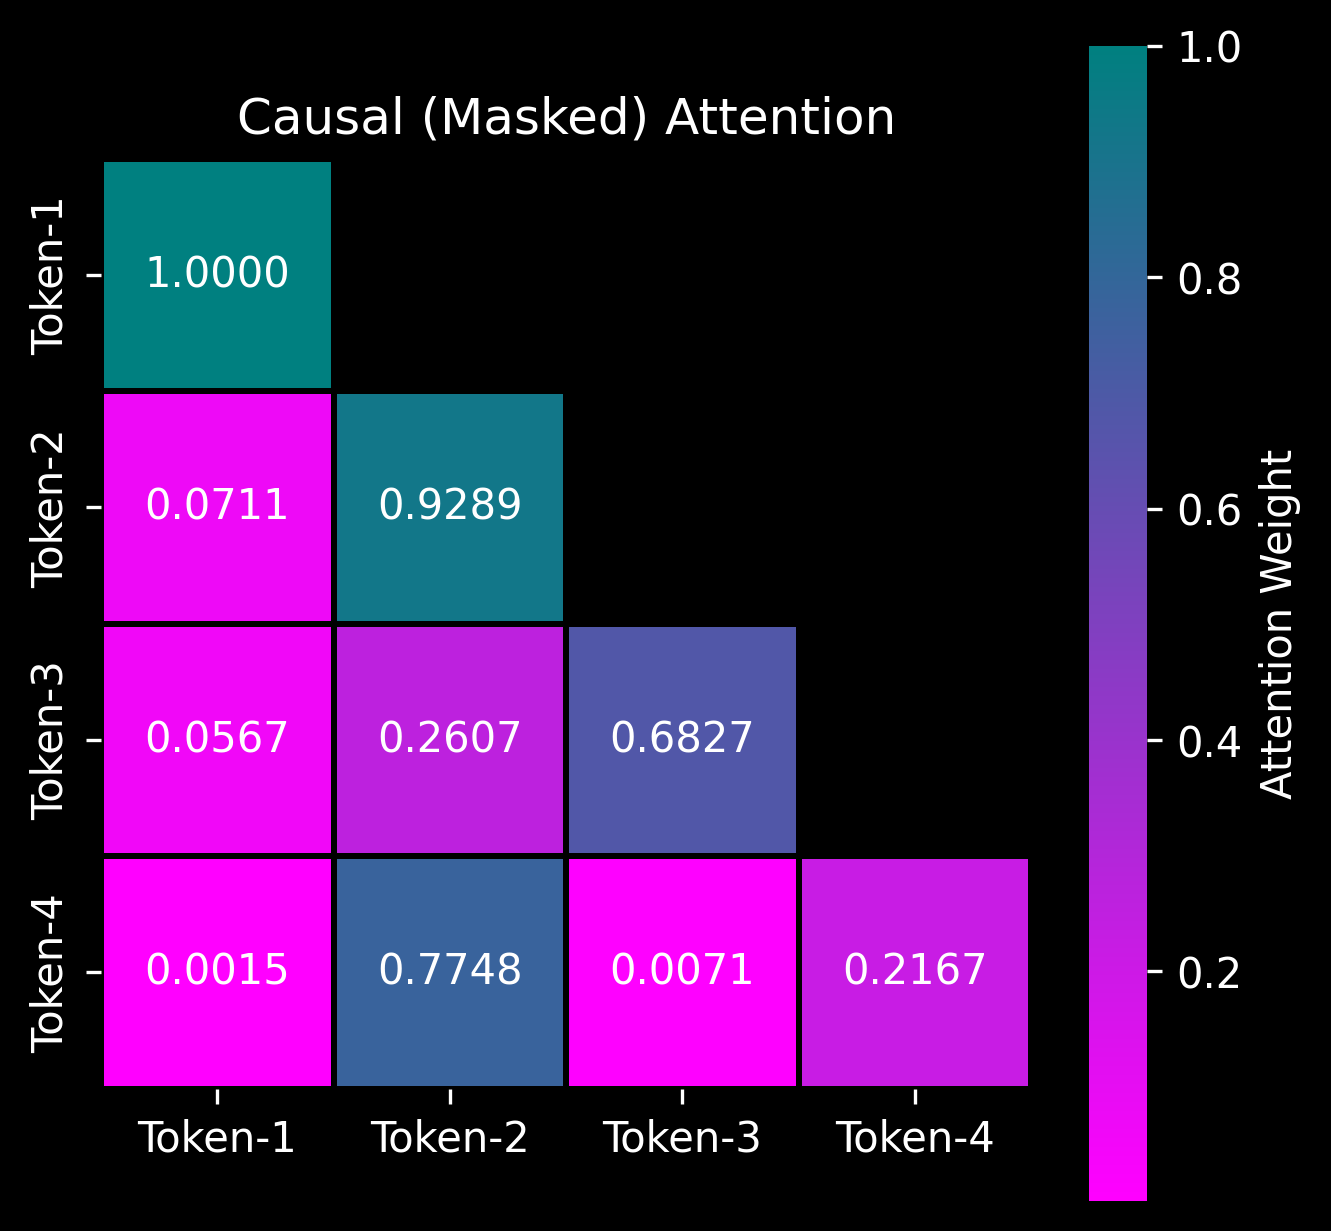

In [2]:
ticklabels = [f'Token-{i}' for i in range(1, 5)]
plt.figure(figsize=(5, 5), dpi=300)
sns.heatmap(
    attention_weights[0, :], 
    annot=True,
    mask=1 - np.tril(np.ones_like(attention_weights[0])),
    annot_kws={'size': 10},
    fmt='.4f',
    cmap=cmap,
    linewidths=1,
    linecolor='black',
    square=True,
    xticklabels=ticklabels,
    yticklabels=ticklabels,
    cbar_kws={'label': 'Attention Weight'}
)
plt.title('Causal (Masked) Attention')
plt.savefig('causal_masked_attention.png', dpi=300)
plt.show()

In [3]:
context_vectors = torch.bmm(attention_weights_torch, value)
assert torch.allclose(context_vectors[0, :][0, :], value[0, :][0])

_Causal Attention ensures that tokens are considered in the direction of causality. Token-1 predicts Token-2, Token-1 and Token-2 predict Token-3, Token-1, Token-2, and Token-3 predict Token-4, and so on. This happens because the context vector is a weighted combination of value vectors, and by making attention weights for future tokens zero, we essentially discard them from influencing the prediction. This ensures that the model generates predictions in an autoregressive manner, where each token can only use information from previous tokens, preserving the natural flow of language generation. By masking future tokens, we prevent the model from "cheating" by looking ahead, maintaining a correct dependency structure._